In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering
import copy

def get_values(data):
    result = []
    for x in data:
        try:
            result.append(x.value)
        except:
            result.append(x)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))
    def log(x):
        if(isinstance(x, pd.Series)):
            return pd.Series([DData.log(y) for y in x])
        if not(isinstance(x, DData)):
            x = DData(x)
        return(DData(np.log(x.value), x.epsilon))
    



<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:208: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\c'
<>:213: SyntaxWarning: invalid escape sequence '\p'
<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:208: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\p'
<>:210: SyntaxWarning: invalid escape sequence '\c'
<>:213: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_2724\2990229007.py:205: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_2724\2990229007.py:208: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_2724\2990229007.py:210: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

In [177]:
data = pd.read_csv("data.csv")
data["d"] = data["d"].apply(lambda x: DData(x,0.05,E=-3))
data["r"] = data["d"]/2
L1 = DData(0.10,0.005)
L2 = DData(0.20,0.005)
data["V"] = (L1/data["t1"] + L2/data["t2"])/2
DData.changeEInSerias(data["V"],-3)
etta = []
rho_zh = []
taos = []
R = DData(20, 1, E=-3)
for i in range(len(data)):
    rho_vodi = DData(1.26,E=3) - 10*(data["T0"][i]-20)/24
    rho_vodi.epsilon = 0.01
    rho_zh.append(rho_vodi)
    if(data["r"][i]<0.55):
        rho = DData(7.7,0.05,E=3)
    else:
        rho = DData(2.6,0.05,E=3)
    cEtta = 2/9*9.81*data["r"][i]**2*(rho-rho_vodi)
    cEtta /= (1+2.4*(data["r"][i]/R))*data["V"][i]
    etta.append(cEtta)
    taos.append(2/9*data["r"][i]**2*rho/cEtta)
data["etta"] = etta
data["rho_zh"] = rho_zh
data["tao"] = taos
data["S"] = data["V"]*data["tao"]
DData.changeEInSerias(data["tao"],-3)
DData.changeEInSerias(data["S"],-6)
DData.changeEInSerias(data["etta"],-3)
data["logEtta"] = DData.log(data["etta"])
data["1/T"] = (1/(data["T0"].apply(lambda x: DData(x,0.3))+273.15))
data["Re"] = data["V"]*data["r"]*1260/data["etta"]
DData.changeEInSerias(data["Re"],0)

data


,T0,d,t1,t2,r,V,etta,rho_zh,tao,S,logEtta,1/T,Re
0,25,$1.950 \pm 0.050$,23.85,47.46,$0.975 \pm 0.025$,$4.20 \pm 0.12$,$592 \pm 42$,$1258 \pm 13$,$0.927 \pm 0.083$,$3.90 \pm 0.36$,$6.384 \pm 0.070$,$0.0033540 \pm 0.0000034$,$0.00872 \pm 0.00069$
1,25,$1.950 \pm 0.050$,23.82,47.88,$0.975 \pm 0.025$,$4.19 \pm 0.12$,$595 \pm 42$,$1258 \pm 13$,$0.924 \pm 0.082$,$3.87 \pm 0.36$,$6.388 \pm 0.070$,$0.0033540 \pm 0.0000034$,$0.00865 \pm 0.00069$
2,25,$0.750 \pm 0.050$,27.90,55.73,$0.375 \pm 0.025$,$3.59 \pm 0.10$,$527 \pm 72$,$1258 \pm 13$,$0.457 \pm 0.087$,$1.64 \pm 0.32$,$6.27 \pm 0.14$,$0.0033540 \pm 0.0000034$,$0.00322 \pm 0.00050$
3,25,$0.700 \pm 0.050$,26.04,52.54,$0.350 \pm 0.025$,$3.82 \pm 0.11$,$432 \pm 63$,$1258 \pm 13$,$0.485 \pm 0.099$,$1.86 \pm 0.38$,$6.07 \pm 0.15$,$0.0033540 \pm 0.0000034$,$0.00390 \pm 0.00064$
4,30,$1.900 \pm 0.050$,17.28,34.29,$0.950 \pm 0.025$,$5.81 \pm 0.16$,$409 \pm 29$,$1256 \pm 13$,$1.28 \pm 0.12$,$7.41 \pm 0.70$,$6.013 \pm 0.071$,$0.0032987 \pm 0.0000033$,$0.0170 \pm 0.0014$
5,30,$1.850 \pm 0.050$,16.50,32.98,$0.925 \pm 0.025$,$6.06 \pm 0.17$,$372 \pm 27$,$1256 \pm 13$,$1.33 \pm 0.12$,$8.05 \pm 0.78$,$5.920 \pm 0.072$,$0.0032987 \pm 0.0000033$,$0.0190 \pm 0.0016$
6,30,$0.650 \pm 0.050$,22.31,44.82,$0.325 \pm 0.025$,$4.47 \pm 0.13$,$319 \pm 50$,$1256 \pm 13$,$0.57 \pm 0.12$,$2.53 \pm 0.56$,$5.77 \pm 0.16$,$0.0032987 \pm 0.0000033$,$0.0057 \pm 0.0010$
7,30,$0.650 \pm 0.050$,24.15,48.75,$0.325 \pm 0.025$,$4.12 \pm 0.12$,$346 \pm 54$,$1256 \pm 13$,$0.52 \pm 0.11$,$2.15 \pm 0.48$,$5.85 \pm 0.16$,$0.0032987 \pm 0.0000033$,$0.00487 \pm 0.00086$
8,35,$2.000 \pm 0.050$,12.27,24.47,$1.000 \pm 0.025$,$8.16 \pm 0.23$,$321 \pm 22$,$1254 \pm 13$,$1.80 \pm 0.16$,$14.7 \pm 1.3$,$5.772 \pm 0.069$,$0.0032452 \pm 0.0000032$,$0.0320 \pm 0.0025$
9,35,$2.100 \pm 0.050$,11.44,22.84,$1.050 \pm 0.025$,$8.75 \pm 0.24$,$328 \pm 22$,$1254 \pm 13$,$1.94 \pm 0.16$,$17.0 \pm 1.5$,$5.794 \pm 0.067$,$0.0032452 \pm 0.0000032$,$0.0352 \pm 0.0027$


In [188]:
data_out = pd.DataFrame()
data_out["t, °C"] = data["T0"]
data_out["r, мм"] = data["r"]
data_out["$t_1$, с"] = data["t1"]
data_out["$t_2$, с"] = data["t2"]
data_out["$\\rho_ж$"] = data["rho_zh"]
data_out["$V_{уст}$, мм/с"] = data["V"]
data_out["$\\eta$, мПа/с"] = data["etta"]
data_out["$\\tau$, мс"] = data["tao"]
data_out["$S_{релакс}$, мкМ"] = data["S"]
data_out["Re"] = pd.Series(get_values(data["Re"])).apply(lambda x: np.round(x, 3))

data_out.to_clipboard()
data_out

,"t, °C","r, мм","$t_1$, с","$t_2$, с",$\rho_ж$,"$V_{уст}$, мм/с","$\eta$, мПа/с","$\tau$, мс","$S_{релакс}$, мкМ",Re
0,25,$0.975 \pm 0.025$,23.85,47.46,$1258 \pm 13$,$4.20 \pm 0.12$,$592 \pm 42$,$0.927 \pm 0.083$,$3.90 \pm 0.36$,0.009
1,25,$0.975 \pm 0.025$,23.82,47.88,$1258 \pm 13$,$4.19 \pm 0.12$,$595 \pm 42$,$0.924 \pm 0.082$,$3.87 \pm 0.36$,0.009
2,25,$0.375 \pm 0.025$,27.90,55.73,$1258 \pm 13$,$3.59 \pm 0.10$,$527 \pm 72$,$0.457 \pm 0.087$,$1.64 \pm 0.32$,0.003
3,25,$0.350 \pm 0.025$,26.04,52.54,$1258 \pm 13$,$3.82 \pm 0.11$,$432 \pm 63$,$0.485 \pm 0.099$,$1.86 \pm 0.38$,0.004
4,30,$0.950 \pm 0.025$,17.28,34.29,$1256 \pm 13$,$5.81 \pm 0.16$,$409 \pm 29$,$1.28 \pm 0.12$,$7.41 \pm 0.70$,0.017
5,30,$0.925 \pm 0.025$,16.50,32.98,$1256 \pm 13$,$6.06 \pm 0.17$,$372 \pm 27$,$1.33 \pm 0.12$,$8.05 \pm 0.78$,0.019
6,30,$0.325 \pm 0.025$,22.31,44.82,$1256 \pm 13$,$4.47 \pm 0.13$,$319 \pm 50$,$0.57 \pm 0.12$,$2.53 \pm 0.56$,0.006
7,30,$0.325 \pm 0.025$,24.15,48.75,$1256 \pm 13$,$4.12 \pm 0.12$,$346 \pm 54$,$0.52 \pm 0.11$,$2.15 \pm 0.48$,0.005
8,35,$1.000 \pm 0.025$,12.27,24.47,$1254 \pm 13$,$8.16 \pm 0.23$,$321 \pm 22$,$1.80 \pm 0.16$,$14.7 \pm 1.3$,0.032
9,35,$1.050 \pm 0.025$,11.44,22.84,$1254 \pm 13$,$8.75 \pm 0.24$,$328 \pm 22$,$1.94 \pm 0.16$,$17.0 \pm 1.5$,0.035


<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_2724\3258077555.py:2: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("ln($\eta$)")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_2724\2990229007.py:212: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")


[0.00306859 0.00337996]
k, b = $6220.0 \pm 400.0$ $-14.6 \pm 1.3$
$8.59 \pm 0.55$ 0.06416068732562019


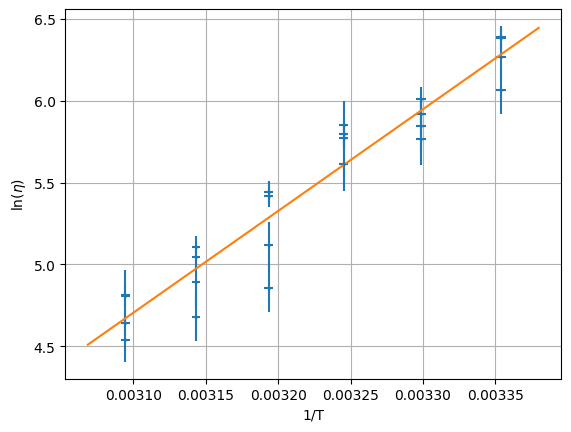

In [189]:
plt.xlabel("1/T")
plt.ylabel("ln($\eta$)")
k, _ = linearcalc_error(data["1/T"],data["logEtta"])
K = DData(1.38, E = -23)
W = k*K
W.E=-20
plt.savefig("graph.png", dpi=300)
print(W, W.epsilon)